# Lab 1 <br> LT13

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Processing

In [408]:
df = pd.read_excel("NomisB.xlsx", na_values=' ')
df['Previous Rate'] = df['Previous Rate'].fillna(0)

In [4]:
df.head()

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin
0,1,743,2002-07-01,36,19100.00,0.0,N,4.95,1,4.85,1.8388,1
1,1,752,2002-07-01,60,36460.08,0.0,N,5.65,1,5.49,1.8388,1
2,1,778,2002-07-01,48,12000.00,0.0,U,5.85,1,5.85,1.8388,3
3,2,724,2002-07-01,60,19290.00,0.0,N,5.65,1,5.39,1.8388,3
4,2,700,2002-07-01,72,24461.12,0.0,N,6.25,1,6.99,1.8388,3


In [409]:
df = df.drop('Approve Date', axis=1)


In [6]:
df.head()

,Tier,FICO,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin
0,1,743,36,19100.00,0.0,N,4.95,1,4.85,1.8388,1
1,1,752,60,36460.08,0.0,N,5.65,1,5.49,1.8388,1
2,1,778,48,12000.00,0.0,U,5.85,1,5.85,1.8388,3
3,2,724,60,19290.00,0.0,N,5.65,1,5.39,1.8388,3
4,2,700,72,24461.12,0.0,N,6.25,1,6.99,1.8388,3


## Some EDA in Python (other EDA are in supplementary and other platforms)

Text(0.5, 1.01, 'Correlation Matrix of Numeric Features')

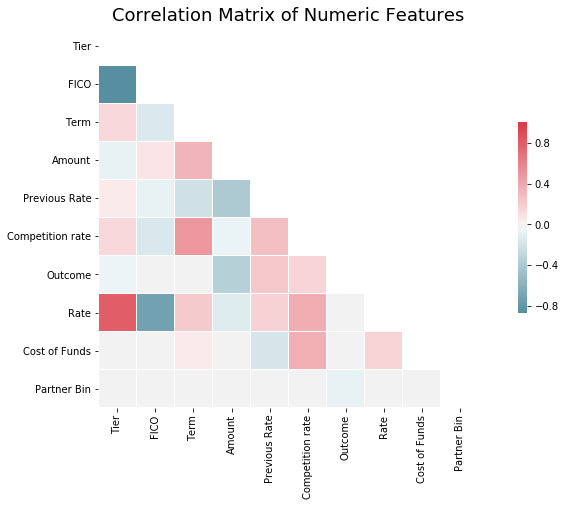

In [7]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
ax.axes.set_title("Correlation Matrix of Numeric Features", fontsize=18, y=1.01)

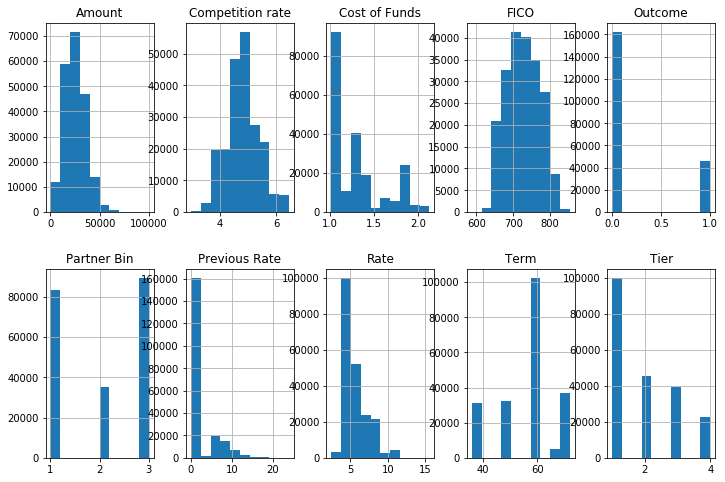

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(12,8))
df.hist(ax=ax);

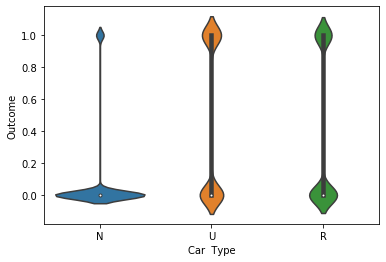

In [36]:
sns.violinplot(data=df, x='Car  Type', y='Outcome')

## Segmenting the data

In [410]:
df_N = df[df['Car  Type']=='N']
df_N = df_N.drop(['Car  Type', 'Previous Rate'], axis=1)

In [249]:
df_U = df[df['Car  Type']=='U']
df_U = df_U.drop(['Car  Type', 'Previous Rate'], axis=1)

In [251]:
df_R = df[df['Car  Type']=='R']
df_R = df_R.drop(['Car  Type'], axis=1)

In [411]:
df_feat_N = pd.get_dummies(df_N, columns=['Partner Bin'])
df_target_N = df_N['Outcome']
df_feat_N = df_feat_N.drop('Outcome',axis=1)

In [256]:
df_feat_U = pd.get_dummies(df_U, columns=['Partner Bin'])
df_target_U = df_U['Outcome']
df_feat_U = df_feat_U.drop('Outcome',axis=1)

df_feat_R = pd.get_dummies(df_R, columns=['Partner Bin'])
df_target_R = df_R['Outcome']
df_feat_R = df_feat_R.drop('Outcome',axis=1)

In [108]:
df_target.value_counts()

0    109894
1      9165
Name: Outcome, dtype: int64

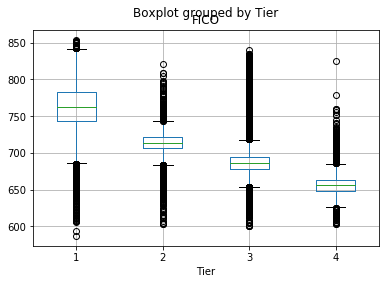

In [109]:
df.boxplot(column='FICO', by='Tier')

## Machine Learning Part

In [111]:

import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import pandas as pd
import pylab as plot
import lmfit as lf
import random

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [ ]:
def logistic(df_feat, df_target, n_iter, t_size, reg, scaler, top_feats=1):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    random_states = random.sample(range(100), n_iter)
    
    best_feats = {i:np.zeros(len(df_feat.columns)) for i in C}
    best_intercepts = {i:0 for i in C}
    for seed in random_states:
        training_accuracy = []  
        test_accuracy = []
#         df_feat_samp = df_feat[df_target==1].sample(df_target.value_counts()[1]).append(df_feat[df_target==0].sample(df_target.value_counts()[1]))
        X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=t_size)
        
        if scaler == 'ss':
            scale = StandardScaler()
            X_train = scale.fit_transform(X = X_train)
            X_test = scale.transform(X = X_test)
        elif scaler == 'mm':
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        else:
            pass
        
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            if scaler:
                coefs = np.mean(lr.coef_, axis=0)
                intercepts = np.mean(lr.intercept_, axis=0)
                best_feats[alpha_run] += coefs / n_iter
                best_intercepts[alpha_run] += intercepts / n_iter
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    score = np.mean(score_test, axis=0)
    feat_coeffs = best_feats[C[np.argmax(score)]]
    intercept = best_intercepts[C[np.argmax(score)]]
    if scaler:
        return [f'Logistic {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler,
                list(zip(df_feat.columns[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]],
                         feat_coeffs[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]])),
                feat_coeffs, intercept]
    else:
        return [f'Logistic {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler]

def svm(df_feat, df_target, n_iter, t_size, reg, scaler, top_feats=1):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    random_states = random.sample(range(100), n_iter)
    best_feats = {i:np.zeros(len(df_feat.columns)) for i in C}
    best_intercepts = {i:0 for i in C}
    for seed in random_states:
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=t_size, random_state=seed)
        
        if scaler == 'ss':
            scale = StandardScaler()
            X_train = scale.fit_transform(X = X_train)
            X_test = scale.transform(X = X_test)
        elif scaler == 'mm':
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        else:
            pass

        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            if scaler:
                coefs = np.mean(svc.coef_, axis=0)
                intercepts = np.mean(svc.intercept_, axis=0)
                best_feats[alpha_run] += coefs / n_iter
                best_intercepts[alpha_run] += intercepts / n_iter

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
          
    score = np.mean(score_test, axis=0)
    feat_coeffs = best_feats[C[np.argmax(score)]]

    if scaler:
        return [f'SVM {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler, 
                list(zip(df_feat.columns[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]],
                         feat_coeffs[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]])),
               feat_coeffs]
    else:
        return [f'SVM {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler]



In [553]:
svm_l1_N = svm(df_feat_N, df_target_N, 20, 0.25, 'l1', 'mm')
# svm_l2_N = svm(df_feat_N, df_target_N, 20, 0.25, 'l2', 'mm', 20)
svm_l1_N

['SVM l1', 92.321, 'C = 1e-08', 'mm', 'Tier']

In [629]:
svm_l2_N = svm(df_feat_N, df_target_N, 20, 0.25, 'l2', 'mm', 20)
# svm_l2_N

In [534]:
log_l2_N = logistic(df_feat_N, df_target_N, 20, 0.25, 'l2', 'mm', 20)
svm_l1_N = svm(df_feat_N, df_target_N, 20, 0.25, 'l1', 'mm', 20)
svm_l2_N = svm(df_feat_N, df_target_N, 20, 0.25, 'l2', 'mm', 20)

In [202]:
log_l1_N = logistic(df_feat_N, df_target_N, 20, 0.25, 'l1', 'mm', 20)
log_l1_N

['Logistic l1',
 92.3062,
 'C = 100',
 'mm',
 [('Amount', -9.167905646876651),
  ('Rate', -3.4264532166235107),
  ('Term', 1.8283310256666025),
  ('Cost of Funds', 1.1102709157749409),
  ('FICO', -0.6604947645591195),
  ('Partner Bin_2', -0.6110115023350889),
  ('Tier', -0.39148390824154444),
  ('Partner Bin_1', 0.3336298115571964),
  ('Competition rate', -0.22348386275491824),
  ('Partner Bin_3', -0.1326826078985141)],
 array([-0.39148391, -0.66049476,  1.82833103, -9.16790565, -0.22348386,
        -3.42645322,  1.11027092,  0.33362981, -0.6110115 , -0.13268261]),
 0.04593412287411823]

In [535]:
log_l2_R = logistic(df_feat_R, df_target_R, 20, 0.25, 'l2', 'mm', 20)
svm_l1_R = svm(df_feat_R, df_target_R, 20, 0.25, 'l1', 'mm', 20)
svm_l2_R = svm(df_feat_R, df_target_R, 20, 0.25, 'l2', 'mm', 20)

In [257]:
log_l1_R = logistic(df_feat_R, df_target_R, 20, 0.25, 'l1', 'mm', 20)
log_l1_R

['Logistic l1',
 68.1098,
 'C = 0.1',
 'mm',
 [('Rate', -4.433098385868142),
  ('Previous Rate', 4.008271949382192),
  ('Amount', -1.6746415867566313),
  ('FICO', -1.4512340342920138),
  ('Partner Bin_2', -1.3749444801829434),
  ('Competition rate', 1.0170673586524004),
  ('Tier', -0.7451011918298407),
  ('Term', 0.5366315378851123),
  ('Cost of Funds', 0.37030708498827175),
  ('Partner Bin_1', 0.33018533228190133),
  ('Partner Bin_3', 0.12725923799579622)],
 array([-0.74510119, -1.45123403,  0.53663154, -1.67464159,  4.00827195,
         1.01706736, -4.43309839,  0.37030708,  0.33018533, -1.37494448,
         0.12725924]),
 0.05443337451613453]

In [536]:
log_l2_U = logistic(df_feat_U, df_target_U, 20, 0.25, 'l2', 'mm', 20)
svm_l1_U = svm(df_feat_U, df_target_U, 20, 0.25, 'l1', 'mm', 20)
svm_l2_U = svm(df_feat_U, df_target_U, 20, 0.25, 'l2', 'mm', 20)

In [258]:
log_l1_U = logistic(df_feat_U, df_target_U, 20, 0.25, 'l1', 'mm', 20)
log_l1_U

['Logistic l1',
 77.8908,
 'C = 3',
 'mm',
 [('Amount', -12.98831814228089),
  ('Rate', -9.858138927608556),
  ('Term', 1.9837762828851537),
  ('Tier', 1.74288389196652),
  ('Competition rate', 1.3675499758344458),
  ('FICO', -0.9983529738517549),
  ('Partner Bin_1', 0.8870592055511479),
  ('Partner Bin_3', 0.5092272659219199),
  ('Cost of Funds', -0.19414269533786707),
  ('Partner Bin_2', 0.0)],
 array([  1.74288389,  -0.99835297,   1.98377628, -12.98831814,
          1.36754998,  -9.85813893,  -0.1941427 ,   0.88705921,
          0.        ,   0.50922727]),
 2.3034431745537756]

In [537]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Scaler', 'Top Predictor Variables', 'Coeffs', 'Intercept']
df_summary_N = pd.DataFrame(columns=cols)

df_summary_N.loc[0] = log_l1_N
df_summary_N.loc[1] = log_l2_N
df_summary_N.loc[2] = svm_l1_N
df_summary_N.loc[3] = svm_l2_N

In [552]:
df_summary_N = df_summary_N.drop(['Scaler', 'Coeffs', 'Intercept', 'Top Predictor Variables'], axis=1)
df_summary_N.loc[3] = ['SVM l2', 92.3208, 'C = 1e-08']
df_summary_N.loc[2] = ['SVM l1', 92.3329, 'C = 1e-08']
df_summary_N

,Machine Learning Method,Test Accuracy,Best Parameter
0,Logistic l1,92.3062,C = 100
1,Logistic l2,92.3323,C = 5
2,SVM l1,92.3329,C = 1e-08
3,SVM l2,92.3208,C = 1e-08


In [538]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Scaler', 'Top Predictor Variables', 'Coeffs', 'Intercept']
df_summary_R = pd.DataFrame(columns=cols)

df_summary_R.loc[0] = log_l1_R
df_summary_R.loc[1] = log_l2_R
df_summary_R.loc[2] = svm_l1_R
df_summary_R.loc[3] = svm_l2_R

In [546]:
df_summary_R.drop(['Scaler', 'Coeffs', 'Intercept', 'Top Predictor Variables'], axis=1)

,Machine Learning Method,Test Accuracy,Best Parameter
0,Logistic l1,68.1098,C = 0.1
1,Logistic l2,68.0357,C = 0.75
2,SVM l1,67.4413,C = 0.1
3,SVM l2,67.6264,C = 0.1


In [539]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Scaler', 'Top Predictor Variables', 'Coeffs', 'Intercept']
df_summary_U = pd.DataFrame(columns=cols)

df_summary_U.loc[0] = log_l1_U
df_summary_U.loc[1] = log_l2_U
df_summary_U.loc[2] = svm_l1_U
df_summary_U.loc[3] = svm_l2_U

In [547]:
df_summary_U.drop(['Scaler', 'Coeffs', 'Intercept', 'Top Predictor Variables'], axis=1)

,Machine Learning Method,Test Accuracy,Best Parameter
0,Logistic l1,77.8908,C = 3
1,Logistic l2,77.7148,C = 300
2,SVM l1,77.2249,C = 5000
3,SVM l2,77.0852,C = 15


Text(0.5, 0, 'Weight')

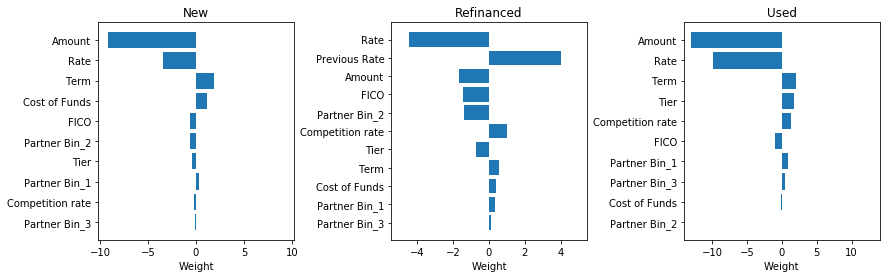

In [522]:
fig, ax = plt.subplots(1, 3, figsize=(14,4), gridspec_kw={'wspace':0.5})
ax[0].barh(*zip(*log_l1_N[4][::-1]))
ax[0].set_title('New')
ax[1].barh(*zip(*log_l1_R[4][::-1]))
ax[1].set_title('Refinanced')
ax[2].barh(*zip(*log_l1_U[4][::-1]))
ax[2].set_title('Used')
ax[0].set_xlim(-np.abs(list(zip(*log_l1_N[4][::-1]))[1]).max()-1, np.abs(list(zip(*log_l1_N[4][::-1]))[1]).max()+1)
ax[1].set_xlim(-np.abs(list(zip(*log_l1_R[4][::-1]))[1]).max()-1, np.abs(list(zip(*log_l1_R[4][::-1]))[1]).max()+1)
ax[2].set_xlim(-np.abs(list(zip(*log_l1_U[4][::-1]))[1]).max()-1, np.abs(list(zip(*log_l1_U[4][::-1]))[1]).max()+1)
ax[0].set_xlabel('Weight')
ax[1].set_xlabel('Weight')
ax[2].set_xlabel('Weight')

## Optimization of profit and captured market

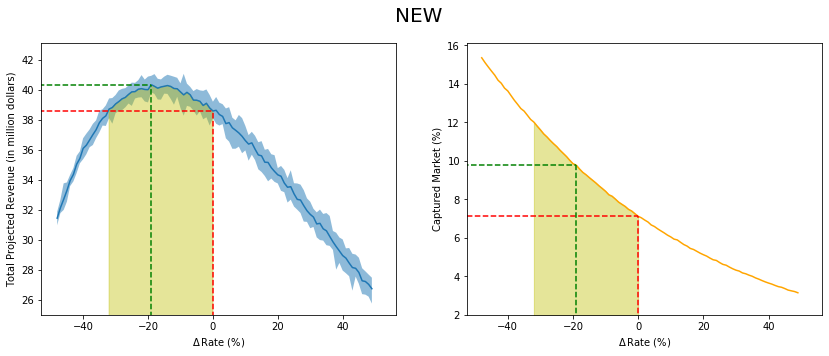

In [617]:
from IPython.display import clear_output
test_acc_N = log_l1_N[1]/100
scaler_N = MinMaxScaler()
scaler_N.fit(df_feat_N)
xs = np.arange(-49, 49, 1)
intercept_N = log_l1_N[-1]
weights_N = log_l1_N[-2]

accepted_Ns = []
profits_Ns = []
for i in xs:
#     print((100 - i)/100)
    dummy = df_feat_N.copy()
    dummy['Rate'] *= (100 - i) / 100
    df_feat_mm = pd.DataFrame(scaler_N.transform(dummy), columns = dummy.columns)
    y = (df_feat_mm*weights_N).sum(axis=1) + intercept_N
    p = 1 / (1 + np.exp(-y))

    accepted_N = []
    profits_N = []
    for _ in range(20):
        diceroll = np.random.random(len(dummy))
        dummys = dummy[(diceroll<p).values]
        profit_person = ((dummys['Amount']*((dummys['Rate'] - dummys['Cost of Funds'])/100)*dummys['Term']/12).reset_index(drop=True))
        profit_total = profit_person[profit_person>0].sum()
        profits_N.append(profit_total)
        accepted_N.append(len(dummys)/len(df_feat_N))
    accepted_Ns.append(accepted_N)
    profits_Ns.append(profits_N)
    
df_N = pd.DataFrame(profits_Ns)
market_share_N = pd.DataFrame(accepted_Ns)

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(-xs, df_N.mean(axis=1),zorder=2)
ax[0].fill_between(-xs, df_N.min(axis=1), df_N.max(axis=1),zorder=1, alpha=0.5)
ax[0].set_yticks(np.arange(26e6, 43e6, 2e6))
ax[0].set_yticklabels([f'{int(i//1e6)}' for i in np.arange(26e6, 43e6, 2e6)])
ax[0].set_xlabel(r'$\Delta\,$Rate (%)')
ax[0].set_ylabel('Total Projected Revenue (in million dollars)')
ax[0].plot([0, 0], [0, df_N.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[0].plot([-xs[np.argmax(df_N.mean(axis=1))], -xs[np.argmax(df_N.mean(axis=1))]], [0, np.max(df_N.mean(axis=1))], 'g--')
ax[0].plot([-100, -xs[np.argmax(df_N.mean(axis=1))]], [np.max(df_N.mean(axis=1)), np.max(df_N.mean(axis=1))], 'g--')
sq_left = np.interp(df_N.mean(axis=1)[xs==0], df_N.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0]
sq_right = 0
sq_bot = df_N.mean(axis=1)[xs==0].iloc[0]
sq_top = df_N.mean(axis=1)[xs==0].iloc[0]
# ax[0].fill_between([sq_left, sq_right], [sq_bot, sq_top], alpha=0.5)
ax[0].fill_between(-xs[(-xs>=sq_left) & (-xs<=sq_right)], df_N.mean(axis=1)[(-xs>=sq_left) & (-xs<=sq_right)], color='y', alpha=0.4)
ax[0].plot([-100, 0], [df_N.mean(axis=1)[xs==0].iloc[0], df_N.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[0].set_ylim(25e6,)
ax[0].set_xlim(-53)
ax[1].plot(-xs, 100*market_share_N.mean(axis=1), c='orange')
ax[1].set_xlabel(r'$\Delta\,$Rate (%)')
ax[1].set_ylabel('Captured Market (%)')
ax[1].plot([0, 0], [0, 100*market_share_N.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].plot([-60, 0], [100*market_share_N.mean(axis=1)[xs==0].iloc[0], 100*market_share_N.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].plot([-xs[np.argmax(df_N.mean(axis=1))], -xs[np.argmax(df_N.mean(axis=1))]],
           [0, (100*market_share_N.mean(axis=1))[np.argmax(df_N.mean(axis=1))]], 'g--')
ax[1].plot([-100, -xs[np.argmax(df_N.mean(axis=1))]],
           [(100*market_share_N.mean(axis=1))[np.argmax(df_N.mean(axis=1))], (100*market_share_N.mean(axis=1))[np.argmax(df_N.mean(axis=1))]], 'g--')
ax[1].set_ylim(2,)
ax[1].set_xlim(-52.5)
ax[1].fill_between(-xs[(-xs>=sq_left) & (-xs<=sq_right)], 100*market_share_N.mean(axis=1)[(-xs>=sq_left) & (-xs<=sq_right)], color='y', alpha=0.4)

fig.suptitle("NEW",size=20);

In [632]:
current_money_N = df_N.mean(axis=1)[xs==0].iloc[0]
current_market_N = 100*market_share_N.mean(axis=1)[xs==0].iloc[0]

max_money_N = np.max(df_N.mean(axis=1))
max_money_market_N = (100*market_share_N.mean(axis=1))[np.argmax(df_N.mean(axis=1))]
max_money_rate_N = -xs[np.argmax(df_N.mean(axis=1))]

max_market_N = np.interp(np.interp(df_N.mean(axis=1)[xs==0], df_N.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0], -xs[::-1], 100*market_share_N.mean(axis=1)[::-1])
max_market_rate_N = np.interp(df_N.mean(axis=1)[xs==0], df_N.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0]

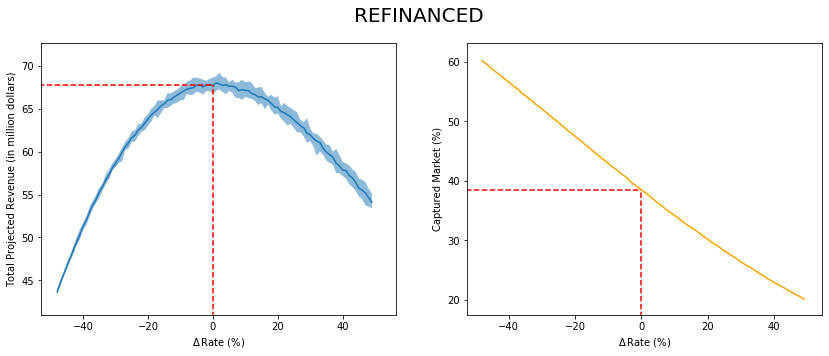

In [620]:
from IPython.display import clear_output
test_acc_R = log_l1_R[1]/100
scaler_R = MinMaxScaler()
scaler_R.fit(df_feat_R)
xs = np.arange(-49, 49, 1)
intercept_R = log_l1_R[-1]
weights_R = log_l1_R[-2]

accepted_Rs = []
profits_Rs = []
for i in xs:
#     print((100 - i)/100)
    dummy = df_feat_R.copy()
    dummy['Rate'] *= (100 - i) / 100
    df_feat_mm = pd.DataFrame(scaler_R.transform(dummy), columns = dummy.columns)
    y = (df_feat_mm*weights_R).sum(axis=1) + intercept_R
    p = 1 / (1 + np.exp(-y))

    accepted_R = []
    profits_R = []
    for _ in range(20):
        diceroll = np.random.random(len(dummy))
        dummys = dummy[(diceroll<p).values]
        profit_person = ((dummys['Amount']*((dummys['Rate'] - dummys['Cost of Funds'])/100)*dummys['Term']/12).reset_index(drop=True))
        profit_total = profit_person[profit_person>0].sum()
        profits_R.append(profit_total)
        accepted_R.append(len(dummys)/len(df_feat_R))
    accepted_Rs.append(accepted_R)
    profits_Rs.append(profits_R)
    
df_R = pd.DataFrame(profits_Rs)
market_share_R = pd.DataFrame(accepted_Rs)

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(-xs, df_R.mean(axis=1),zorder=2)
ax[0].fill_between(-xs, df_R.min(axis=1), df_R.max(axis=1),zorder=1, alpha=0.5)
ax[0].set_yticks(np.arange(35e6, 71e6, 5e6))
ax[0].set_yticklabels([f'{int(i//1e6)}' for i in np.arange(35e6, 71e6, 5e6)])
ax[0].set_xlabel(r'$\Delta\,$Rate (%)')
ax[0].set_ylabel('Total Projected Revenue (in million dollars)')
ax[0].plot([0, 0], [0, df_R.mean(axis=1)[xs==0].iloc[0]], 'r--')
# ax[0].plot([-xs[np.argmax(df_R.mean(axis=1))], -xs[np.argmax(df_R.mean(axis=1))]], [0, np.max(df_R.mean(axis=1))], 'r--')
ax[0].plot([-100, 0], [df_R.mean(axis=1)[xs==0].iloc[0], df_R.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[0].set_ylim(41e6,)
ax[0].set_xlim(-53)
ax[1].plot(-xs, 100*market_share_R.mean(axis=1), c='orange')
ax[1].set_xlabel(r'$\Delta\,$Rate (%)')
ax[1].set_ylabel('Captured Market (%)')
ax[1].plot([0, 0], [0, 100*market_share_R.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].plot([-60, 0], [100*market_share_R.mean(axis=1)[xs==0].iloc[0], 100*market_share_R.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].set_ylim(17.5,)
ax[1].set_xlim(-52.5)
fig.suptitle("REFINANCED",size=20);

In [640]:
current_money_R = df_R.mean(axis=1)[xs==0].iloc[0]
current_market_R = 100*market_share_R.mean(axis=1)[xs==0].iloc[0]

max_money_R = np.max(df_R.mean(axis=1))
max_money_market_R = (100*market_share_R.mean(axis=1))[np.argmax(df_R.mean(axis=1))]
max_money_rate_R = -xs[np.argmax(df_R.mean(axis=1))]


max_market_R = np.interp(np.interp(df_R.mean(axis=1)[xs==0], df_R.mean(axis=1)[(-xs)<(5)][::-1], (-xs)[(-xs)<(5)][::-1])[0], -xs[::-1], 100*market_share_R.mean(axis=1)[::-1])

max_market_rate_R = np.interp(df_R.mean(axis=1)[xs==0], df_R.mean(axis=1)[(-xs)<(5)][::-1], (-xs)[(-xs)<(5)][::-1])[0]

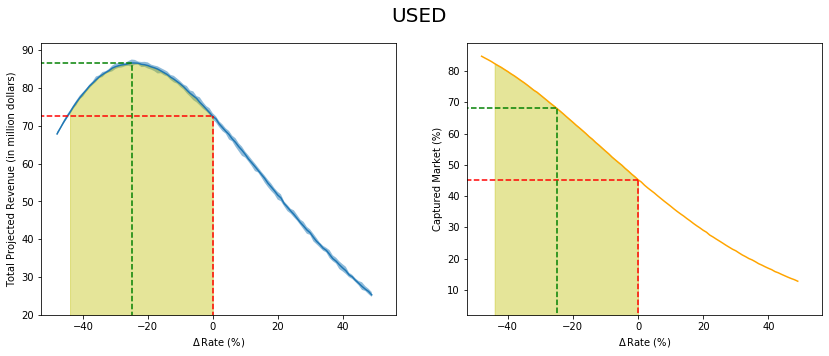

In [622]:
from IPython.display import clear_output
test_acc_U = log_l1_U[1]/100
scaler_U = MinMaxScaler()
scaler_U.fit(df_feat_U)
xs = np.arange(-49, 49, 1)
intercept_U = log_l1_U[-1]
weights_U = log_l1_U[-2]

accepted_Us = []
profits_Us = []
for i in xs:
#     print((100 - i)/100)
    dummy = df_feat_U.copy()
    dummy['Rate'] *= (100 - i) / 100
    df_feat_mm = pd.DataFrame(scaler_U.transform(dummy), columns = dummy.columns)
    y = (df_feat_mm*weights_U).sum(axis=1) + intercept_U
    p = 1 / (1 + np.exp(-y))

    accepted_U = []
    profits_U = []
    for _ in range(20):
        diceroll = np.random.random(len(dummy))
        dummys = dummy[(diceroll<p).values]
        profit_person = ((dummys['Amount']*((dummys['Rate'] - dummys['Cost of Funds'])/100)*dummys['Term']/12).reset_index(drop=True))
        profit_total = profit_person[profit_person>0].sum()
        profits_U.append(profit_total)
        accepted_U.append(len(dummys)/len(df_feat_U))
    accepted_Us.append(accepted_U)
    profits_Us.append(profits_U)
    
df_U = pd.DataFrame(profits_Us)
market_share_U = pd.DataFrame(accepted_Us)

fig, ax = plt.subplots(1, 2, figsize=(14,5))
sq_left = np.interp(df_U.mean(axis=1)[xs==0], df_U.mean(axis=1)[(-xs)<(-30)][::-1], (-xs)[(-xs)<(-30)][::-1])[0]
sq_right = 0
sq_bot = df_U.mean(axis=1)[xs==0].iloc[0]
sq_top = df_U.mean(axis=1)[xs==0].iloc[0]
ax[0].plot(-xs, df_U.mean(axis=1),zorder=2)
ax[0].fill_between(-xs, df_U.min(axis=1), df_U.max(axis=1),zorder=1, alpha=0.5)
ax[0].set_yticks(np.arange(20e6, 91e6, 10e6))
ax[0].set_yticklabels([f'{int(i//1e6)}' for i in np.arange(20e6, 91e6, 10e6)])
ax[0].set_xlabel(r'$\Delta\,$Rate (%)')
ax[0].set_ylabel('Total Projected Revenue (in million dollars)')
ax[0].plot([0, 0], [0, df_U.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[0].plot([-xs[np.argmax(df_U.mean(axis=1))], -xs[np.argmax(df_U.mean(axis=1))]], [0, np.max(df_U.mean(axis=1))], 'g--')
ax[0].plot([-100, -xs[np.argmax(df_U.mean(axis=1))]], [np.max(df_U.mean(axis=1)), np.max(df_U.mean(axis=1))], 'g--')
ax[0].plot([-100, 0], [df_U.mean(axis=1)[xs==0].iloc[0], df_U.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[0].fill_between(-xs[(-xs>=sq_left) & (-xs<=sq_right)], df_U.mean(axis=1)[(-xs>=sq_left) & (-xs<=sq_right)], color='y', alpha=0.4)
ax[0].set_ylim(20e6,)
ax[0].set_xlim(-53)
ax[1].plot(-xs, 100*market_share_U.mean(axis=1), c='orange')
ax[1].set_xlabel(r'$\Delta\,$Rate (%)')
ax[1].set_ylabel('Captured Market (%)')
ax[1].plot([0, 0], [0, 100*market_share_U.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].plot([-60, 0], [100*market_share_U.mean(axis=1)[xs==0].iloc[0], 100*market_share_U.mean(axis=1)[xs==0].iloc[0]], 'r--')
ax[1].plot([-xs[np.argmax(df_U.mean(axis=1))], -xs[np.argmax(df_U.mean(axis=1))]],
           [0, (100*market_share_U.mean(axis=1))[np.argmax(df_U.mean(axis=1))]], 'g--')
ax[1].plot([-100, -xs[np.argmax(df_U.mean(axis=1))]],
           [(100*market_share_U.mean(axis=1))[np.argmax(df_U.mean(axis=1))], (100*market_share_U.mean(axis=1))[np.argmax(df_U.mean(axis=1))]], 'g--')
ax[1].fill_between(-xs[(-xs>=sq_left) & (-xs<=sq_right)], 100*market_share_U.mean(axis=1)[(-xs>=sq_left) & (-xs<=sq_right)], color='y', alpha=0.4)
ax[1].set_ylim(2,)
ax[1].set_xlim(-52.5)
fig.suptitle("USED",size=20);

In [634]:
current_money_U = df_U.mean(axis=1)[xs==0].iloc[0]
current_market_U = 100*market_share_U.mean(axis=1)[xs==0].iloc[0]

max_money_U = np.max(df_U.mean(axis=1))
max_money_market_U = (100*market_share_U.mean(axis=1))[np.argmax(df_U.mean(axis=1))]
max_money_rate_U = -xs[np.argmax(df_U.mean(axis=1))]

max_market_U = np.interp(np.interp(df_U.mean(axis=1)[xs==0], df_U.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0], -xs[::-1], 100*market_share_U.mean(axis=1)[::-1])
max_market_rate_U = np.interp(df_U.mean(axis=1)[xs==0], df_U.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0]

In [642]:
tuples = [('Current', 'Profit (in million dollars)'), ('Current', 'Captured market (%)'), ('Maximum profit','Profit (in million dollars)'), ('Maximum profit','Captured market (%)'), ('Maximum profit','Rate Change (%)'), ('Maximum captured market','Capture market (%)'), ('Maximum captured market','Rate Change (%)')]
index = pd.MultiIndex.from_tuples(tuples, names=['', ''])
df_summary2 = pd.DataFrame(columns=index)
pd.options.display.float_format = '{:,.2f}'.format

df_summary2.loc['New'] = [current_money_N/1e6, current_market_N, max_money_N/1e6, max_money_market_N, max_money_rate_N, max_market_N, max_market_rate_N]
df_summary2.loc['Used'] = [current_money_U/1e6, current_market_U, max_money_U/1e6, max_money_market_U, max_money_rate_U, max_market_U, max_market_rate_U]
df_summary2.loc['Refinanced'] = [current_money_R/1e6, current_market_R, max_money_R/1e6, max_money_market_R, max_money_rate_R, max_market_R, max_market_rate_R]

In [643]:
df_summary2

Current                      \
           Profit (in million dollars) Captured market (%)   
New                              38.58                7.12   
Used                             72.46               45.23   
Refinanced                       67.70               38.51   

                        Maximum profit                                      \
           Profit (in million dollars) Captured market (%) Rate Change (%)   
New                              40.33                9.78          -19.00   
Used                             86.59               68.13          -25.00   
Refinanced                       67.98               38.09            1.00   

           Maximum captured market                  
                Capture market (%) Rate Change (%)  
New                          12.05          -32.28  
Used                         82.92          -44.84  
Refinanced                   40.85           -5.10

In [575]:
current_money_N = df_N.mean(axis=1)[xs==0].iloc[0]
current_market_N = 100*market_share_N.mean(axis=1)[xs==0].iloc[0]

max_money_N = np.max(df_N.mean(axis=1))
max_money_market_N = (100*market_share_N.mean(axis=1))[np.argmax(df_N.mean(axis=1))]
max_money_rate_N = -xs[np.argmax(df_N.mean(axis=1))]

max_market_N = np.interp(np.interp(df_N.mean(axis=1)[xs==0], df_N.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0], -xs[::-1], 100*market_share_N.mean(axis=1)[::-1])
max_money_rate_N = np.interp(df_N.mean(axis=1)[xs==0], df_N.mean(axis=1)[(-xs)<(-25)][::-1], (-xs)[(-xs)<(-25)][::-1])[0]

In [532]:
-xs[np.argmax(df_U.mean(axis=1))]

-25

In [533]:
(100*market_share_U.mean(axis=1))[np.argmax(df_U.mean(axis=1))]

68.08661756265545